#  <center> Feature Extraction for Tweet Classification </center>

##  <center> Please support me with an upvote if you find this notebook useful 👍 </center>

# Content

<a id="toc"></a>

- [1. Import Libraries and Data](#1)
        
        
- [2. Exploratory Data Analysis](#2)
    - 2.1 Output Varaible
    - 2.2 Number of Characters
    - 2.3 Number of Words
    - 2.4 Average Length of Words
    - 2.5 Word Cloud
    
  
- [3. Data Preparation](#3)
    - 3.1 Split the Tweets
    - 3.2 Preprocess the Tweets


- [4. Feature Extraction](#4)
    - 4.1 The Frequency Dictionary
    - 4.2 Feature Extraction Function
    

- [5. Modelling with Logistic Regression](#5)
    - 5.1 Cross-Validation
    - 5.2 Train the model
    
    
- [6. Make Predictions](#5)

<a id="1"></a>

# <center> Import Libraries and Data </center>

In this notebook, we will use the **nltk** library for **text processing** and the **sklearn** library for implementing the logistic regression model. Therefore, our first step is to import these libraries. Then, we will import the train, test and sample submission files.

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import re                                 
import string                           

import nltk                               
from wordcloud import WordCloud
from nltk.corpus import stopwords       
from nltk.stem import PorterStemmer      
from nltk.tokenize import TweetTokenizer, word_tokenize     

from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_validate, KFold, cross_val_score

In [2]:
df_train = pd.read_csv('../input/nlp-getting-started/train.csv')
df_test = pd.read_csv('../input/nlp-getting-started/test.csv')
submission = pd.read_csv('../input/nlp-getting-started/sample_submission.csv')

In [3]:
print(f'There are {len(df_train)} training data and {len(df_test)} test data.')

There are 7613 training data and 3263 test data.


In [4]:
display(df_train.head())
display(df_test.head())

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


<a id="2"></a>

# <center> Exploratory Data Analysis </center>

## Output Variable

**How many** of the tweets in the **training set** are indicating **real disasters**? 

We can plot a **pie chart** to visualize the proportion of the **real** and **fake** tweets.

The percentage of real and fake disaster tweets in the training set:


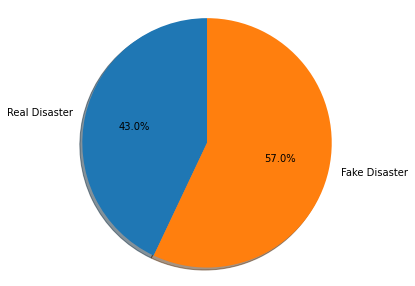

In [5]:
print('The percentage of real and fake disaster tweets in the training set:')
fig = plt.figure(figsize=(5,5))
labels = 'Real Disaster', 'Fake Disaster'
sizes = [len(df_train[df_train['target']==1]), len(df_train[df_train['target']==0])] 
plt.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
plt.axis('equal')  
plt.show()

## Number of Characters

Plot a **histogram** to visualize the **distribution** of the **number of characters** in a tweet.

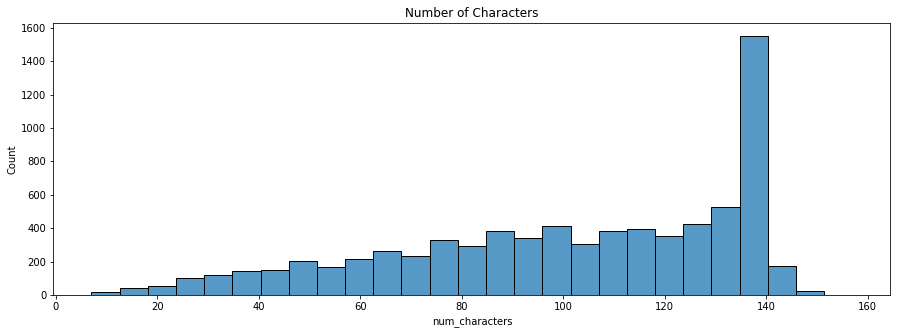

In [6]:
#calculate the number of characters in each tweet
df_train['num_characters'] = df_train['text'].str.len()    

#plot the distribution of the number of characters
fig = plt.figure(figsize=(15, 5))
sns.histplot(data=df_train, x="num_characters")
plt.title("Number of Characters")
plt.show()

**Compare the distributions** of the number of characters for **real** (target=1) and **fake** (target=0) tweets.

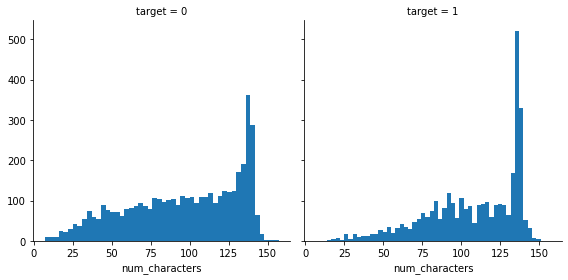

In [7]:
g = sns.FacetGrid(df_train, col='target', height=4)
g.map(plt.hist, 'num_characters', bins=50)
plt.show()

## Number of Words

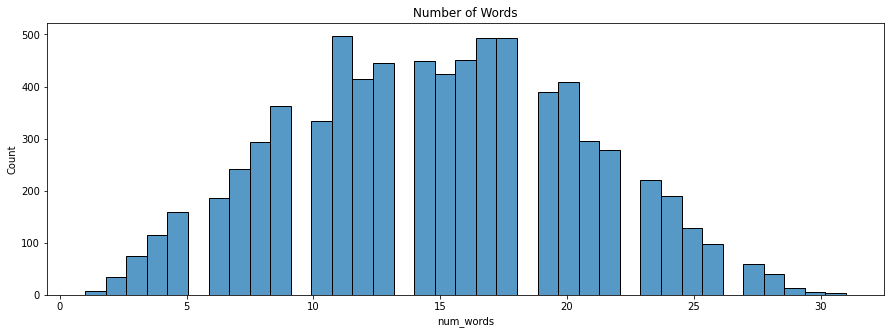

In [8]:
#compute the number of words in each tweet
df_train['num_words'] = df_train['text'].apply(lambda x: len(x.split()))

#plot the distribution of the number of words
fig = plt.figure(figsize=(15, 5))
sns.histplot(data=df_train, x="num_words")
plt.title("Number of Words")
plt.show()

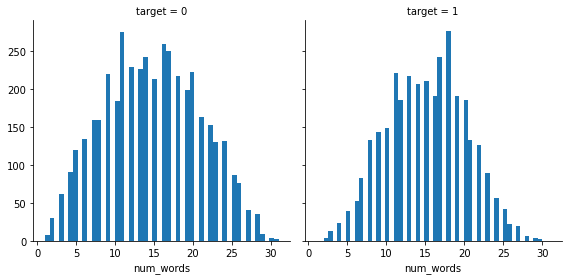

In [9]:
g = sns.FacetGrid(df_train, col='target', height=4)
g.map(plt.hist, 'num_words', bins=50)
plt.show()

## Average Word Length

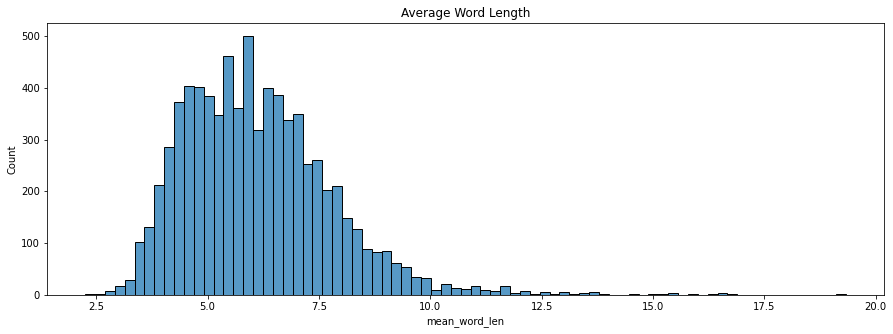

In [10]:
#compute the average length of words for each tweet
df_train['mean_word_len'] = df_train['text'].str.split().apply(lambda x : np.mean([len(i) for i in x]))

#plot the distribution of the average length of words
fig = plt.figure(figsize=(15, 5))
sns.histplot(data=df_train, x="mean_word_len")
plt.title("Average Word Length")
plt.show()

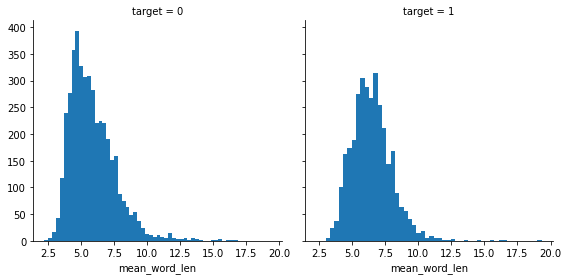

In [11]:
g = sns.FacetGrid(df_train, col='target', height=4)
g.map(plt.hist, 'mean_word_len', bins=50)
plt.show()

## Word Cloud

Generate a **word cloud** to visualize the **most frequent** words used in all the tweets.

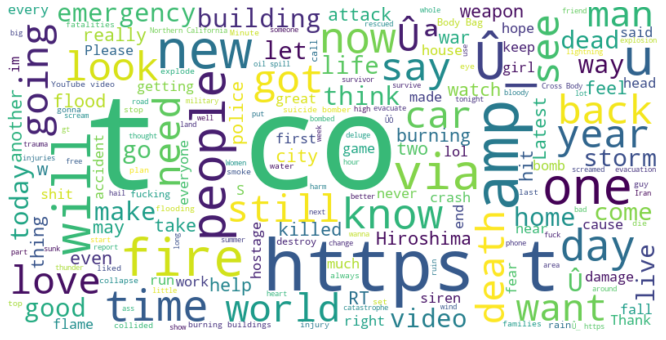

In [12]:
wordcloud = WordCloud(background_color='white', width=800, height=400).generate(''.join(df_train['text']))
plt.figure(figsize=(20, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

<a id="3"></a>

# <center> Data Preparation </center>

## Split the Tweets

We split the tweets into **true** (target=1) and **fake** (target=0) tweets and **stored them seperately** in lists.

Then, we **combine** the 2 lists together which will give us all the tweets in the training set.

In [13]:
all_true_tweets = list(df_train[df_train['target']==1]['text'])
all_fake_tweets = list(df_train[df_train['target']==0]['text'])
tweets = all_true_tweets + all_fake_tweets

## Text Preprocessing

There are in total **4 steps** of text preprocessing

1. remove the **hyperlinks** and **hashtags**
2. **tokenize** the sentences into **samller units** (i.e. words)
3. remove the **stop words** and **punctuations**
4. simply the words through **stemming**

In the following block of code, each step is **demonstrated seperately** and the resultant texts are printed at each stage to show the effects.

In [14]:
tweet = '@someone You must check his beautiful notebooks this morning!!! https://www.kaggle.com/ryanluoli2 #NLP'

print('The original tweet: ', tweet)
print()

tweet = re.sub(r'https?://[^\s\n\r]+', '', tweet)     #remove hyperlinks
tweet = re.sub(r'#', '', tweet)                       #remove the hashtags
print('Removed hyperlinks and hash signs: ', tweet)
print()

tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)  
tweet_tokens = tokenizer.tokenize(tweet)              #tokenize the sentence into words
print('Tokenized tweet: ', tweet_tokens)
print()

stopwords_english = stopwords.words('english')        #import the english stop words list
tweets_clean = [] 
for word in tweet_tokens:                             #remove the stopwords and punctuations
    if (word not in stopwords_english) & (word not in string.punctuation):  
        tweets_clean.append(word)
print('Cleaned tweet: ', tweets_clean)
print()

stemmer = PorterStemmer()
tweets_stem = [] 
for word in tweets_clean:
    stem_word = stemmer.stem(word)  
    tweets_stem.append(stem_word)  
print('Stemmed tweet: ', tweets_stem)

The original tweet:  @someone You must check his beautiful notebooks this morning!!! https://www.kaggle.com/ryanluoli2 #NLP

Removed hyperlinks and hash signs:  @someone You must check his beautiful notebooks this morning!!!  NLP

Tokenized tweet:  ['you', 'must', 'check', 'his', 'beautiful', 'notebooks', 'this', 'morning', '!', '!', '!', 'nlp']

Cleaned tweet:  ['must', 'check', 'beautiful', 'notebooks', 'morning', 'nlp']

Stemmed tweet:  ['must', 'check', 'beauti', 'notebook', 'morn', 'nlp']


Now, let's put all these steps into a **single function** to make things easier!

In [15]:
def process_tweet(tweet):
    #initialize the tools
    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('english')
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
    
    tweet = re.sub(r'\$\w*', '', tweet)                   #remove stock market tickers like $GE
    tweet = re.sub(r'^RT[\s]+', '', tweet)                #remove old style retweet text "RT"
    tweet = re.sub(r'https?://[^\s\n\r]+', '', tweet)     #remove hyperlinks
    tweet = re.sub(r'#', '', tweet)                       #remove hashtags
    tweet_tokens = tokenizer.tokenize(tweet)              #tokenize the tweets
    tweets_clean = []
    for word in tweet_tokens:
        if (word not in stopwords_english and             #remove stopwords
                word not in string.punctuation):          #remove punctuations
            stem_word = stemmer.stem(word)                # stem the words
            tweets_clean.append(stem_word)
            
    return tweets_clean

In [16]:
tweet = '@someone You must check his beautiful notebooks this morning!!! https://www.kaggle.com/ryanluoli2 #NLP'
process_tweet(tweet)

['must', 'check', 'beauti', 'notebook', 'morn', 'nlp']

<a id="4"></a>

# <center> Feature Extraction </center>

In this notebook, I would like to introduce to you a **feature extraction** method that uses only **3 features** to represent the **text inputs**. This method can not only be applied to this specific problem, but is also suitable for any **binary classification** NLP problems.

Let's consider an **example tweet**: "The sky is burning".

**Step 1**: Find out **how many times** do the words appear in the **true** and **fake** tweets, for example, the word **"burning"** may appear 25 times in all the true tweets and 12 times in all the fake tweets. 25 is known as the **positive frequecy** and 12 is the **negative frequency**.

**Step 2**: Sum up the positive frequencies of all the words and the result is the feature **PosFreq**. Similarly, summing up all the negative frequencies gives you the feature **NegFreq**.

For example, given the **counts (pos,neg)** for words: the = (10,8), sky = (4,9), is = (10,10), burning = (25,12)

**PosFreq** = 10 + 4 + 10 + 25 = 49

**NegFreq** = 8 + 9 + 10 + 12 = 39

**Step 3**: Repeat step 1 and 2 for all the tweets and then we have **2 features** to represent the tweets.

**Step 4**: Add a **bias term** of ones as an additional feature

## The Frequency Dictionary

In order to perform feature extraction with less effort, we can first obtain a **frequency dictionary** storing the **positive and negative counts** of the words. With this dictionary, we don't have to compute the frequencies of the words again and again each time we need to use them.

In [17]:
#return a dictionary storing how many counts of the words in both negative and positive
def build_freqs(tweets, labels):
    freqs = {}
    for tweet, label in zip(tweets, list(labels)):
        for word in process_tweet(tweet):
            pair = (word, label)
            freqs[pair] = freqs.get(pair, 0) + 1
    return freqs

In [18]:
tweets  = all_true_tweets + all_fake_tweets
labels = np.append([1]*len(all_true_tweets), [0]*len(all_fake_tweets))

freq_dict = build_freqs(tweets, labels)

for i in range(5):
    word = list(freq_dict.keys())[i]
    print(word, freq_dict[word])

('deed', 1) 1
('reason', 1) 8
('earthquak', 1) 47
('may', 1) 50
('allah', 1) 6


As you can see, the **frequency dictionary** stores the **positive frequency** of the word **deed** as **('deed',1)** where the count is 1.

## Feature Extraction Function

Here, we define a function to perform the **feature extraction** process mentioned above, that is: to calculate the **PosFreq** and **NegFreq** for each tweet and add a **bias** of 1.

In [19]:
def extract_features(tweets, freq_dict):
    df = pd.DataFrame(columns=['bias','pos','neg'])
    pos_sums, neg_sums = [], []
    for tweet in tweets:
        pos, neg = 0, 0
        cleaned_tweet = process_tweet(tweet)
        for word in list(set(cleaned_tweet)):
            if (word,1) in freq_dict:
                pos += freq_dict[(word, 1)]
            if (word,0) in freq_dict:
                neg += freq_dict[(word, 0)]
        pos_sums.append(pos)
        neg_sums.append(neg)
    df['pos'] = pos_sums
    df['neg'] = neg_sums
    df['bias'] = np.ones(len(df))
    return df

In [20]:
#extract features for the training tweets
train_features = extract_features(tweets, freq_dict)
train_features['labels'] = labels
train_features.head()

,bias,pos,neg,labels
0,1.0,162,148,1
1,1.0,402,120,1
2,1.0,229,107,1
3,1.0,429,144,1
4,1.0,196,212,1


In [21]:
#split the features into inputs X and output y
X_train = train_features[['bias','pos','neg']]
y_train = train_features['labels']

In [22]:
#don't forget to extract features for the test tweets too
test_features = extract_features(df_test['text'], freq_dict)
test_features.head()

,bias,pos,neg
0,1.0,220,121
1,1.0,141,133
2,1.0,416,184
3,1.0,101,59
4,1.0,245,34


## Modelling with Logistic Regression

In [23]:
lr = LogisticRegression(max_iter=2000, random_state=0)
cv_scores = cross_validate(lr, X_train, y_train, cv=5, scoring='accuracy')
print('The cross-validation F1-score of the model is: ', round(cv_scores['test_score'].mean(),5), end=' ')
print('with a variance of: ', round(cv_scores['test_score'].std(),5))

The cross-validation F1-score of the model is:  0.76383 with a variance of:  0.02662


# Make Predictions

In [24]:
lr.fit(X_train, y_train)
y_pred = lr.predict(test_features[['bias','pos','neg']])

submission['target'] = y_pred
submission.to_csv('submission.csv', index=False)
submission.head()

,id,target
0,0,1
1,2,0
2,3,1
3,9,1
4,11,1
